In [16]:
#!/usr/bin/env python
# coding: utf-8


# compare summa outputs from different levels of complexity
import os, datetime
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm 

# ========== User settings ==================================
root_dir='/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/calib'
basinName='06282000' #'06279940'

# hru inputs
levelArray=['0', '1a', '1b', '1c', '2a', '2b', '2c', '3']
# summaVarList=['scalarSWE','scalarTotalSoilWat','pptrate_mean','airtemp_mean',
#          'scalarTotalET_mean','scalarTotalRunoff_mean'] # a list of summa variables for plot
summaVarList=['scalarTotalSoilWat','pptrate_mean','airtemp_mean',
         'scalarTotalET_mean','scalarTotalRunoff_mean'] # a list of summa variables for plot

# model and calib result directories
model_dir = '/glade/u/home/hongli/scratch/2020_06_02HRUcomplexity/model'
sim_dir = os.path.join(root_dir,basinName,'analysis/5_best_calib_results')

# hru shapefile
discretize_dir = '/glade/work/andywood/complexity/basins/bighorn'
case_dir = os.path.join(discretize_dir,basinName)
# stream_clip = os.path.join(discretize_dir, case, 'stream.shp')
wgs_crs = 'epsg:4326' #WGS 84

# plot inputs
time_format = '%Y-%m-%d'
plot_date_start = '2007-10-01' #'2007-10-01'
plot_date_end = '2008-09-30'
plot_date_start_obj = datetime.datetime.strptime(plot_date_start, time_format)
plot_date_end_obj = datetime.datetime.strptime(plot_date_end, time_format)
plot_date_range = (pd.date_range(start=plot_date_start,end=plot_date_end,freq='M')-pd.offsets.MonthBegin(1)).to_pydatetime().tolist() #freq='D'

# var_names_summa = ['SWRadAtm','LWRadAtm','scalarSWE']
# var_names_plot = ['Shortwave Rad','Longwave Rad','SWE']
# var_units_plot = ['$(W/m^2)$','$(W/m^2)$','$(mm)$'] 
# cmaps=['OrRd','GnBu','YlGn']
            
output_dir=os.path.join(root_dir,basinName,'analysis/8_plot_summa_output_space')
output_subdir=os.path.join(output_dir,'plot_daily')
if not os.path.exists(output_subdir):
    os.makedirs(output_subdir)

# ========== end User settings ==================================

# ============== PART 1. Read data ==============
# --- read summa input & output
print('read')
data_dic = {}      # complexity levels -> variables per level
varNameList = []   # all variables for plot (forcings + summa)
varUnitList = []   # al variable unit for plot

for complexity_level in levelArray[-1]:
    print('-- ',complexity_level)
    data_lev_dic = {}
    
    # read variables from summa output
    for var in summaVarList:
        q_ncfile = os.path.join(sim_dir,complexity_level+'_DDS','wbout_day.nc')
        ds = xr.open_dataset(q_ncfile) 
        time = ds['time'].values[:]
        time = pd.to_datetime(time)

        data = ds[var].values[:] # (time, hru). unit: 'mm'    
        data_lev_dic[var] = pd.DataFrame(data, index=time)
        
        if complexity_level == levelArray[0]:
            varNameList.extend([var])
            varUnitList.extend([ds[var].units[:]])

    # read radiation from summa input
    plot_start_yr = plot_date_start_obj.year
    plot_end_yr = plot_date_end_obj.year
    for yr in range(plot_start_yr, plot_end_yr+1):
        force_ncfile = os.path.join(model_dir,basinName,'forcings/summa_3hr_hru_lev'+complexity_level, 
                        'ens_forc.'+basinName+'.huc12.'+str(yr)+'.001.nc')
        ds = xr.open_dataset(force_ncfile) 
        time = ds['time'].values[:]
        time = pd.to_datetime(time)

        SWRadAtm = ds['SWRadAtm'].values[:] # (time, hru). unit: W m-2    
        LWRadAtm = ds['LWRadAtm'].values[:] # (time, hru). unit: W m-2    

        if yr == plot_start_yr:
            time_concat = time
            SWRadAtm_concat = SWRadAtm
            LWRadAtm_concat = LWRadAtm
            
            # add unit
            if complexity_level == levelArray[0]:
                varNameList.extend(['SWRadAtm','LWRadAtm'])
                varUnitList.extend([ds['SWRadAtm'].units[:]])
                varUnitList.extend([ds['LWRadAtm'].units[:]])
        else:
            time_concat = np.concatenate((time_concat, time), axis=0)
            SWRadAtm_concat = np.concatenate((SWRadAtm_concat, SWRadAtm), axis=0)
            LWRadAtm_concat = np.concatenate((LWRadAtm_concat, LWRadAtm), axis=0)

        # calculate daily mean of 3-hr radiation
        df_SW = pd.DataFrame(SWRadAtm_concat, index=time_concat)
        df_LW = pd.DataFrame(LWRadAtm_concat, index=time_concat)

        df_SW_avg = df_SW.resample('D').mean()
        df_LW_avg = df_LW.resample('D').mean()    

        data_lev_dic['SWRadAtm'] = df_SW_avg
        data_lev_dic['LWRadAtm'] = df_LW_avg

        # save to the big dic
        data_dic[complexity_level]=data_lev_dic

# # --- read HRU shapefile
# print('read HRU shapefile')
# hru_gpd_dic = {}
# for complexity_level in levelArray:

#     # read HRU shapefile 
#     hru_vector_elmn = os.path.join(discretize_dir, basinName, 'results', 
#                                    'hru_lev'+complexity_level+'_elmn.shp')          
#     hru_gpd = gpd.read_file(hru_vector_elmn)
#     hru_gpd_prj = hru_gpd.to_crs(wgs_crs)
#     hru_gpd_dic[complexity_level]=hru_gpd_prj

# # --- read GRU shapefile
# sub_shp_prj = os.path.join(discretize_dir, basinName, 'results', 
#                            'hru_lev'+levelArray[0]+'_elmn.shp') 
# gru_gpd = gpd.read_file(sub_shp_prj)
# gru_gpd_prj = gru_gpd.to_crs(wgs_crs)

# ============== PART 3. Daily plot ==============
print('plot')
# for t_obj in tqdm(plot_date_range):
for t_obj in tqdm(plot_date_range[0:1]):
    t_obj_str = t_obj.strftime('%Y-%m-%d')
    
#     for iVar in range(len(varNameList)): # variable
    for iVar in range(4,5): # variable
        
        var = varNameList[iVar]
        var_unit = varUnitList[iVar]           
        
        print(t_obj_str+'\t'+var)

        # --- identify min and max for this variable on this date over all complexities.
        vmin_levs = []
        vmax_levs = []
        for complexity_level in levelArray:    

            # extract usefule variable value
            df = data_dic[complexity_level][var]
            df_cut = df.truncate(before=t_obj, after=t_obj)
            data = df_cut.to_numpy() 
            
#             vmin_lev,vmax_lev = np.nanmin(data),np.nanmax(data)
            
            vmin_lev = np.nanmin(data)
            Q1,Q3 = np.percentile(data,15), np.percentile(data,75)
            vmax_lev = Q3 + 1.5*(Q3-Q1)

            vmin_levs.append(vmin_lev)
            vmax_levs.append(vmax_lev)
            
        vmin,vmax = np.min(vmin_levs), np.max(vmax_levs)
        # --- 
        
#         # plot one figure for each variable on this date.
#         ncol = 2
#         nrow = int(np.ceil(len(levelArray)/ncol)) # all complexity levels
        
#         fig, ax = plt.subplots(nrow, ncol,figsize=[7.08, 7.08*0.3*nrow], constrained_layout=True)
#         fig.suptitle(t_obj_str+' '+var, fontsize='medium',weight='semibold')

#         for i in range(nrow): 
#             for j in range(ncol):
                
#                 comp_id = i*ncol + j
#                 if comp_id < len(levelArray):
                
#                     complexity_level = levelArray[comp_id]

#                     # identify variable and unit 
#                     hru_gpd_prj = hru_gpd_dic[complexity_level]

#                     # extract usefule variable value
#                     df = data_dic[complexity_level][var] # dataframe (time, hru)
#                     df_cut = df.truncate(before=t_obj, after=t_obj)  
#                     data = df_cut.to_numpy()
#                     data = data.reshape((np.shape(data)[1],np.shape(data)[0]))            

#                     # plot
#                     # (1) plot gru
#                     gru_gpd_prj.geometry.boundary.plot(color=None,edgecolor='k',linewidth=0.3,
#                                                        ax=ax[i,j],label='GRU') 

#                     # (2) plot data (in hru)
#                     # reference: https://geopandas.org/docs/user_guide/mapping.html
#                     # reference: https://www.martinalarcon.org/2018-12-31-d-geopandas/
#                     hru_gpd_prj[var] = data
                   
# #                     hru_gpd_prj.plot(column=var, ax=ax[i,j], cmap='jet', legend=False,
# #                             vmin=vmin, vmax=vmax) #cax=cax, legend=True,
                    
#                     divider = make_axes_locatable(ax[i,j])
#                     cax = divider.append_axes("right", size="4.5%", pad="-0.5%") 
                    
#                     if var != 'scalarTotalRunoff_mean':
#                         hru_gpd_prj.plot(column=var, ax=ax[i,j], cmap='jet', legend=True,cax=cax,
#                                          vmin=vmin, vmax=vmax)
#                     elif var == 'scalarTotalRunoff_mean':
#                         hru_gpd_prj.plot(column=var, ax=ax[i,j], cmap='jet', legend=True,cax=cax)

#                     # Set the fontsize for each colorbar tick label
#                     # manipulate the colorbar `cax`
# #                     cax.set_title(var_unit, fontsize='small')
#                     cax.set_ylabel('('+var_unit+')', rotation=-90, va="bottom", fontsize='small')
#                     for l in cax.yaxis.get_ticklabels():
#                         l.set_fontsize('small')

#                     # others
#                     subtitle = complexity_level
#                     ax[i,j].set_title(subtitle,fontsize='small',weight='semibold')
#                     ax[i,j].tick_params(axis='both', direction='out', labelsize='small')
#                 else:
#                     ax[i,j].axis('off')
                
# #         # add colorbar
# #         cax = fig.add_axes([0.4, 0.05, 0.2, 0.02]) #[left, bottom, width, height]
# #         sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# #         # fake up the array of the scalar mappable. Urgh...
# #         sm._A = []
# #         fig.colorbar(sm, cax=cax, orientation="horizontal")         

#         ofile = var+'_'+t_obj.strftime('%Y%m%d')+'.png'
#         plt.savefig(os.path.join(output_subdir,ofile), dpi=80)
#         plt.close(fig)    

# ## Then convert daily plots to gif using command line.
# ## convert -delay 10 plot_daily/*.png test.gif
# print('Done')


read
--  3


  0%|          | 0/1 [00:00<?, ?it/s]

plot


IndexError: list index out of range

In [17]:
df_cut = data_lev_dic['scalarTotalRunoff_mean'].truncate(before=t_obj, after=t_obj)
df_cut

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
2007-10-01,5.103468e-15,4.971706e-15,2.601145e-13,4.970544e-15,4.528221e-15,4.530597e-15,4.982085e-15,3.985493e-15,5.929031e-13,4.981029e-15,...,2.574438e-15,2.717949e-15,2.230611e-15,2.271640e-15,2.177566e-15,2.215571e-15,2.759984e-15,2.772152e-15,2.750293e-15,2.784034e-15


In [43]:
Q1,Q3 = np.percentile(df_cut,15), np.percentile(df_cut,75)
vmax = Q3 + 1.5*(Q3-Q1)
np.percentile(df_cut,99),vmax

(1.1126908725997352e-12, 8.100985753387155e-15)

In [42]:
vmax

8.100985753387155e-15

In [39]:
np.where(df_cut>9.74836767e-10)
np.where(df_cut>1.1126908725997352e-12)

(array([0, 0, 0]), array([ 14, 133, 150]))

In [41]:
df_cut.iloc[0,14],df_cut.iloc[0,133],df_cut.iloc[0,150]

(1.0831517e-09, 1.458875e-12, 1.7718307e-12)

In [15]:
data_lev_dic['scalarTotalRunoff_mean'][data_lev_dic['scalarTotalRunoff_mean']>1.0e-05]

,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
2005-10-01,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.00001,0.00001,0.00001,0.00001,0.000011,0.000011,0.000011,0.000011
2005-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(array([252.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.17756585e-15, 1.08317126e-10, 2.16632073e-10, 3.24947041e-10,
        4.33261982e-10, 5.41576950e-10, 6.49891863e-10, 7.58206831e-10,
        8.66521799e-10, 9.74836767e-10, 1.08315168e-09], dtype=float32),
 <a list of 10 Patch objects>)

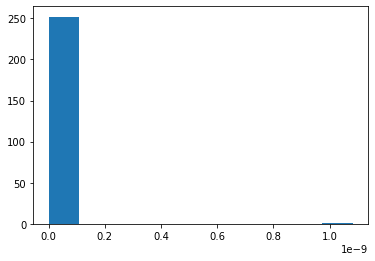

In [21]:
plt.hist(df_cut)